In [2]:
from kb_python.utils import import_matrix_as_anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import anndata
import pickle

def nd(arr):
    return np.asarray(arr).reshape(-1)
from matplotlib.ticker import LogLocator, NullFormatter

def fix_ticks(ax, axis=['x']):
    locmin = LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=25)
    locmaj = LogLocator(base=10,numticks=25)
    if 'x' in axis:
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.xaxis.set_major_locator(locmaj)
    if 'y' in axis:
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_locator(locmaj)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib

### Import cellranger barcodes as "ground truth barcodes"

In [4]:
ds = "human-pbmc10k_v3"
ref = "human-grch38"

In [5]:
base = f"../../data/plotting/{ds}"
kb_common = anndata.read_h5ad(os.path.join(base, 'kb_common.h5ad'))
alevin_common = anndata.read_h5ad(os.path.join(base, 'alevin_common.h5ad'))
kb_common_cr = anndata.read_h5ad(os.path.join(base, 'kb_common_cr.h5ad'))
alevin_common_cr = anndata.read_h5ad(os.path.join(base, 'alevin_common_cr.h5ad'))

with open(os.path.join(base, 'cc_raw.pkl'), 'rb') as fp:
    cc_raw = pickle.load(fp)

x = np.sort(nd(kb_common_cr.X.sum(axis=1)))[::-1]
minkb = min(x)

# ## Alevin
x = np.sort(nd(alevin_common_cr.X.sum(axis=1)))[::-1]

minal = min(x)

cutoff = min(minkb, minal)

cutoff_mask = kb_common.obs['counts']>=cutoff

kb_common.var['gid'] = kb_common.var.index.values
kb_common_cr.var['gid'] = kb_common_cr.var.index.values

In [6]:
t2g = pd.read_csv(f'../../reference/{ref}/t2g.txt', sep="\t", header = None, names=['tid', 'gid', 'gene'])

t2g.index = t2g['gid']

In [7]:
mt = t2g[t2g.gene.str.upper().str.startswith('MT-')]['gid'].values

mt

array(['ENSG00000198888', 'ENSG00000198763', 'ENSG00000198804',
       'ENSG00000198712', 'ENSG00000228253', 'ENSG00000198899',
       'ENSG00000198938', 'ENSG00000198840', 'ENSG00000212907',
       'ENSG00000198886', 'ENSG00000198786', 'ENSG00000198695',
       'ENSG00000198727'], dtype=object)

# Mito


In [8]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [9]:
k = nd(kb_common[:, kb_common.var.gid.isin(mt)].X.sum(axis=1))/kb_common.obs['counts'].values

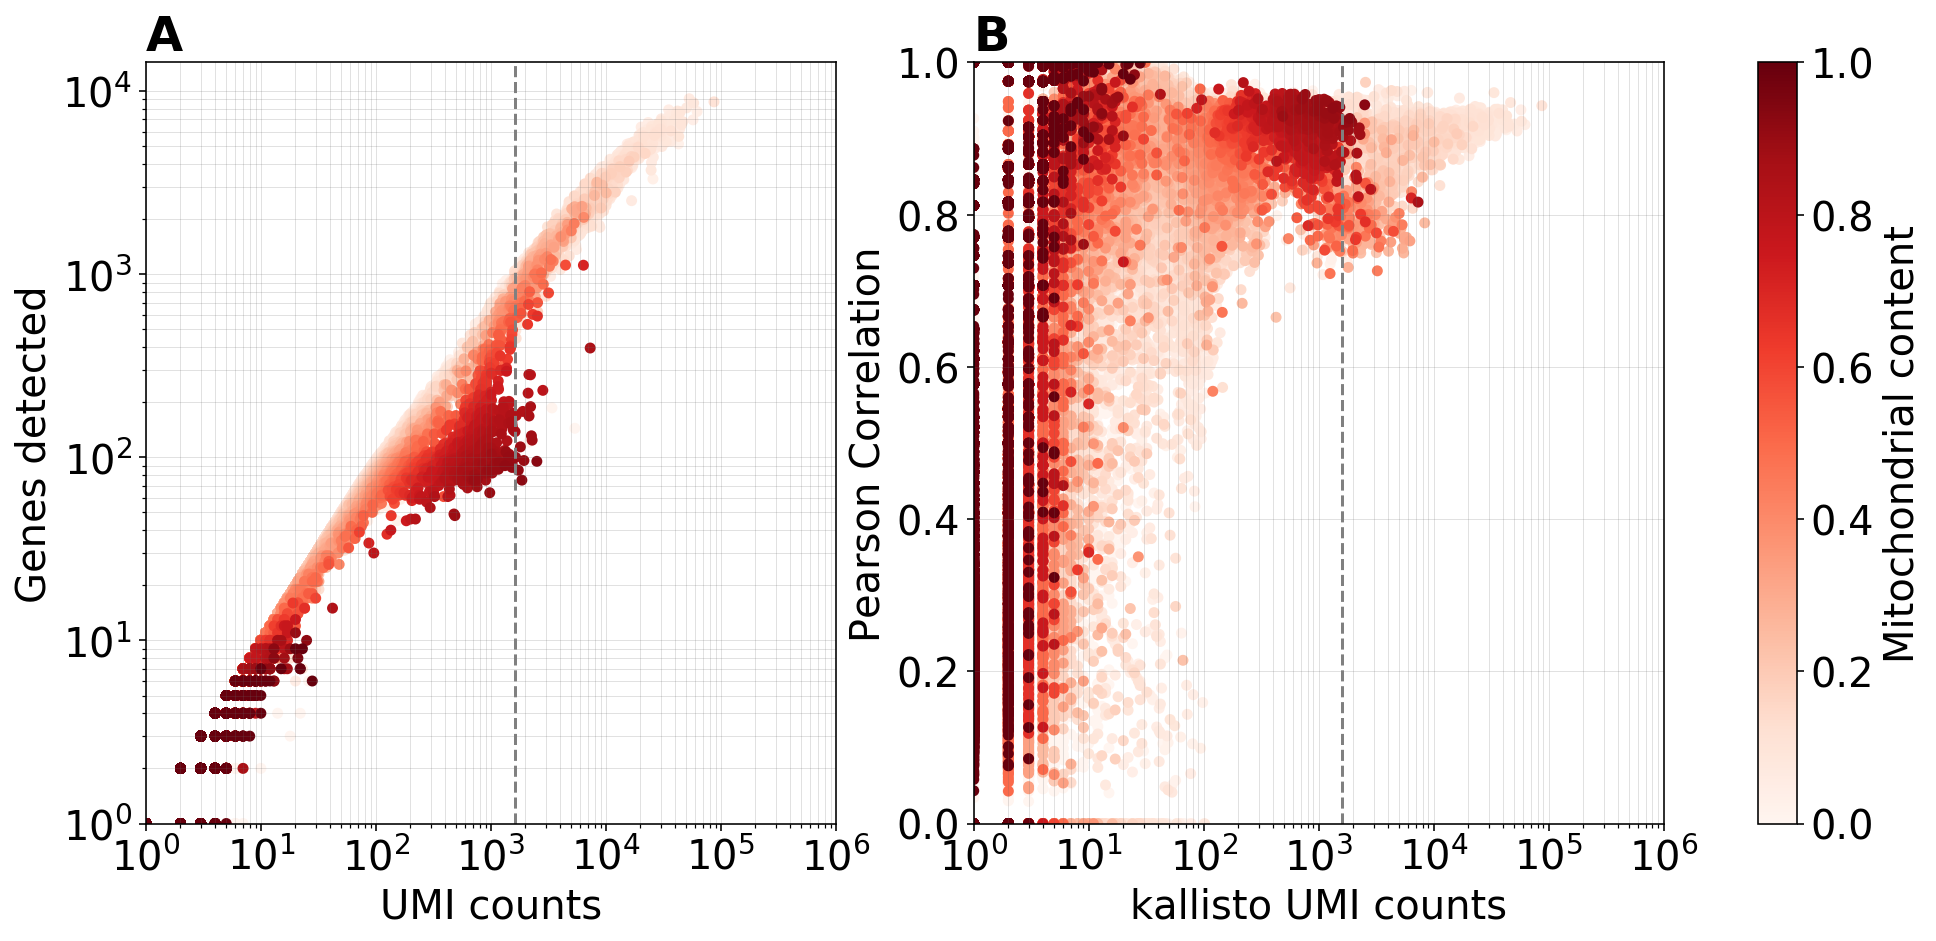

In [10]:
fig, axs = plt.subplots(figsize=(17,7), ncols=2)

argsort = np.argsort(k)
kk = k[argsort]


############## genes detected
ax = axs[0]

title = "A"

x = kb_common.obs['counts'].values
y = kb_common.obs['ngenes'].values


xx = x[argsort]
yy = y[argsort]

sc = ax.scatter(xx,yy, s=20, label='kallisto', c = kk, cmap='Reds')

ax.axvline(x=cutoff, color="grey", linestyle="--")


ax.set(**{
    'xscale': 'log',
    'yscale': 'log',
    'xlim': (1, 10**6),
    'ylim': (1),
    'xlabel': 'UMI counts',
    'ylabel': 'Genes detected'
})


fix_ticks(ax, ['x', 'y'])

# # Customize the major grid
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

ax.set_title(title, fontweight='bold', loc = 'left' )

############ Correlation
ax = axs[1]

title = "B"

x = kb_common.obs['counts'].values
y = cc_raw

xx = x[argsort]
yy = y[argsort]

sc = ax.scatter(xx,yy, s=20, c=kk, cmap = "Reds")

ax.axvline(x=cutoff, color="grey", linestyle="--")

ax.set(**{
    'xscale': 'log',
    "xlim": (1, 10**6),
    'ylim': (0,1),
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'Pearson Correlation'
})
fix_ticks(ax, ['x'])

fig.colorbar(sc, ax=axs.ravel().tolist(), label='Mitochondrial content')

# Customize the major grid
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

ax.set_title(title, fontweight='bold', loc = 'left' )
plt.savefig('mito.png', dpi=300, bbox_inches='tight')
fig.show()